# Flamant's problem (analytical and numerical solution)

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/foundation_eng/blob/main/notebooks/flamants_line_load.ipynb).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* pygmsh V6.0.2 [Schlömer et al. (2019a)](https://doi.org/10.5281/zenodo.3541027)
* meshio V3.3.1 [Schlömer et al. (2019b)](https://doi.org/10.5281/zenodo.3584511)
* And other packages for general scientific programming in Python


## Setting up the environment

### Installing dependencies

In [1]:
!sudo apt-get install -y python-gmsh
!pip install meshio==3.3.1
!pip install pygmsh==6.0.2
!pip install solidspy==1.0.16

### Required modules

In [2]:
import pygmsh
import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol


### Global configuration for plots

In [3]:
plt.style.use("default")
# plt.rcParams["image.cmap"] = "Set1"
plt.rcParams["image.cmap"] = 'cubehelix'
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
        "image.cmap": 'PiYG'
    }
)


## Functions

### FEM solution

#### Creating the domain and meshing it

In [4]:
def create_domain(x_load=0, y_load=0, l=20, z=10, elem_size=1.0):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    '''
    # Empty structure
    geom = pygmsh.built_in.Geometry()
    # Points
    p1 = geom.add_point([x_load + 0.0, y_load + 0.0, 0.0], elem_size/5)
    p2 = geom.add_point([x_load - l / 2, y_load + 0.0, 0.0], elem_size)
    p3 = geom.add_point([x_load - l / 2, y_load - z, 0.0], elem_size)
    p4 = geom.add_point([x_load + l / 2, y_load - z, 0.0], elem_size)
    p5 = geom.add_point([x_load + l / 2, y_load + 0, 0.0], elem_size)
    # Lines
    l1 = geom.add_line(p1, p2)  # Upper line 1
    l2 = geom.add_line(p2, p3)  # Rigth line
    l3 = geom.add_line(p3, p4)  # Bottom line
    l4 = geom.add_line(p4, p5)  # Left line
    l5 = geom.add_line(p5, p1)  # Upper line 2
    # Surfaces
    ll1 = geom.add_line_loop([l1, l2, l3, l4, l5])
    s1 = geom.add_plane_surface(ll1)
    # Physical groups
    geom.add_physical(s1, label="100")  # Material
    geom.add_physical(p1, label="200")  # Point load
    geom.add_physical([l2, l4], label="300")  # Lateral boundary
    geom.add_physical(l3, label="400")  # Lower boundary
    geom.add_physical([l5, l1], label="500")  # Upper boundary
    # Generate the mesh
    mesh = pygmsh.generate_mesh(
        geom, geo_filename="mesh.geo", msh_filename="mesh.msh"
    )
    return mesh

def plot_mesh(nodes, elements, loads):
    tri_mesh = pos.mesh2tri(nodes, elements)
    load = nodes[int(loads[0, 0])]
    plt.triplot(tri_mesh, marker=".", lw=0.5, ms=2, color="tomato")
    plt.arrow(x=load[1], y=load[2]+1, dx=0, dy=-1, width=.05,  fc='k', ec='k', length_includes_head=True)
    # plt.text(load[1], load[2]+1.3, '$P$', horizontalalignment='center', verticalalignment='bottom')
    plt.axis("image")
    plt.xlabel('$x$  [m]')
    plt.ylabel('$y$  [m]')
    return

def get_a_value(x, y, field, nodes, elements):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    '''
    tri_mesh = pos.mesh2tri(nodes, elements)
    interpolator = mpl.tri.CubicTriInterpolator(tri_mesh, z=field, kind='geom')
    return float(interpolator(x, y))


#### Creating solidspy inputs

In [5]:
def solidspy_inputs(mesh, elasticity_mod, poisson_rat, load_x, load_y):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    - Loads (forces) in [N/m]
    '''
    points = mesh.points
    cells = mesh.cells
    point_data = mesh.point_data
    cell_data = mesh.cell_data
    field_data = mesh.field_data
    # Element data
    eles = cells["triangle"]
    els_array = np.zeros([eles.shape[0], 6], dtype=int)
    els_array[:, 0] = range(eles.shape[0])
    els_array[:, 1] = 3
    els_array[:, 3::] = eles.data
    # Nodes
    nodes_array = np.zeros([points.shape[0], 5])
    nodes_array[:, 0] = range(points.shape[0])
    nodes_array[:, 1:3] = points[:, :2]
    # Loads
    id_cargas = cells["vertex"]
    loads_array = np.array([[id_cargas[0][0], load_x, load_y]])
    # Boundaries
    lines = cells["line"]
    bounds = cell_data["line"]["gmsh:physical"]
    nbounds = len(bounds)
    id_izq_der = [cont for cont in range(nbounds) if bounds[cont] == 3]
    id_inf = [cont for cont in range(nbounds) if bounds[cont] == 4]
    nodes_izq_der = lines[id_izq_der].flatten()
    nodes_inf = lines[id_inf].flatten()
    nodes_array[nodes_izq_der, 3] = -1
    nodes_array[nodes_inf, 3:] = (-1, -1)
    #  Material
    mats_array = np.array([[elasticity_mod, poisson_rat]])
    return (nodes_array, mats_array, els_array, loads_array)


#### Executing the solver

In [6]:
def run_solidspy(nodes, mats, elements, loads):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    '''
    # System assembly
    assem_op, bc_array, neq = ass.DME(nodes, elements)
    stiff_mat = ass.assembler(elements, mats, nodes, neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)
    # System solution
    disp = sol.static_sol(stiff_mat, rhs_vec)
    # Post-processing
    # Fill the displacement vectors with imposed and computed values
    disp = pos.complete_disp(bc_array, nodes, disp)
    # Averaged strains and stresses at nodes
    strain, stress = pos.strain_nodes(nodes, elements, mats, disp)
    # Compute the principal directions of a tensor field
    eigs1, eigs3, vecs1, vecs3 = pos.principal_dirs(stress)
    return (disp, strain, 1e-3*stress, 1e-3*eigs1, 1e-3*eigs3, vecs1, vecs3)


## Analytical solution

In [7]:
def flamant(x, y, load_y=-1e9, poisson_rat=0.3):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    - Loads (forces) in [N/m]
    - Stress in [kPa]
    '''
    load_y = -1 * load_y
    r = np.sqrt(x**2 + y**2)
    if type(r) == np.ndarray:
        r[np.where(r < 0.001)] = 0.001
    elif any((type(r) == int, float)) and r < 0.001:
        r = 0.001
    sigma_x = 1e-3 * (2 * load_y * x**2 * y) / (np.pi * r**4)
    sigma_y = 1e-3 * (2 * load_y * y**3) / (np.pi * r**4)
    sigma_z = 1e-3 * (2 * load_y * poisson_rat * y) / (np.pi * r**2)
    tau_xy = 1e-3 * (2 * load_y * x * y**2) / (np.pi * r**4)
    sigma_1 = 1e-3 * (2 * load_y * y) / (np.pi * r**2)
    sigma_2 = 0 * sigma_x
    sigma_3 = sigma_z
    return sigma_x, sigma_y, sigma_z, tau_xy, sigma_1, sigma_2, sigma_3

## Comparing solutions

In [8]:
def compare_solutions(x, y, field='xx'):
    '''Parameters in the International System of Units.
    - Lengths (and coordinates) in [m]
    - Loads (forces) in [N/m]
    - Stress in [kPa]
    '''
    sigma_xx_a, sigma_yy_a, sigma_z_a, tau_xy_a, sigma_1_a, sigma_2_a, sigma_3_a = flamant(x, y, load, poisson_rat)
    stress = {
        'xx': ('𝜎_xx', sigma_xx, sigma_xx_a),
        'yy': ('𝜎_yy', sigma_yy, sigma_yy_a),
        'xy': ('𝜏_xy', tau_xy, tau_xy_a),
        '1': ('𝜎_1', sigma_1, sigma_1_a),
        '3': ('𝜎_3', sigma_3, sigma_3_a),
    }
    field_at_xy_FEM = get_a_value(x, y, stress[f'{field}'][1], nodes, elements)
    print(stress[f'{field}'][0] + f' at ({x}, {y}) by FEM is {field_at_xy_FEM:.2f} kPa')
    field_at_xy_AS = stress[field][2]
    print(stress[f'{field}'][0] + f' at ({x}, {y}) by analytical solution is {field_at_xy_AS:.2f} kPa')
    return

## Running a case

In [9]:
# GLOBAL INPUTS
load = -1e5  # [N/m]
elasticity_mod = 50e6  # [N/m²]
poisson_rat = 0.3
domain_width = 20  # [m]
domain_depth = 20  # [m]

# FEM SOLUTION
# Creating the domain and meshing it
mesh = create_domain(x_load=0, y_load=0, l=domain_width, z=domain_depth, elem_size=1)
# Creating solidspy inputs
nodes, mats, elements, loads = solidspy_inputs(
    mesh, elasticity_mod, poisson_rat, load_x=0, load_y=load
)
# Coordinates at nodes
x, y = nodes[:, 1:3].T
# Executing the FEM solver
disp, strain, stress, sigma_1, sigma_3, vecs1, vecs3 = run_solidspy(
    nodes, mats, elements, loads
)
sigma_xx, sigma_yy, tau_xy = stress[:, 0], stress[:, 1], stress[:, 2]

# ANALYTICAL SOLUTION
sigma_xx_a, sigma_yy_a, sigma_zz_a, tau_xy_a, sigma_1_a, sigma_2_a, sigma_3_a = flamant(
    x, y, load, poisson_rat
)

Info    : Running '/home/eamontoyaa/.pyenv/versions/3.9.13/envs/solidspy-env/bin/gmsh -3 mesh.geo -format msh -bin -o mesh.msh' [Gmsh 4.10.5, 1 node, max. 1 thread]
Info    : Started on Fri Sep  9 16:45:35 2022
Info    : Reading 'mesh.geo'...
Info    : Done reading 'mesh.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00315537s, CPU 0.003157s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0182569s, CPU 0.017471s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 2.1207e-05s, CPU 6e-06s)
Info    : 870 nodes 1743 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'
Info    : Stopped on Fri Sep  9 16:45:35 2022 (From start: Wall 0.0370211s, CPU 0.75205s)

msh file: mesh.msh

geo file: 

## Plotting results

### FEM solution

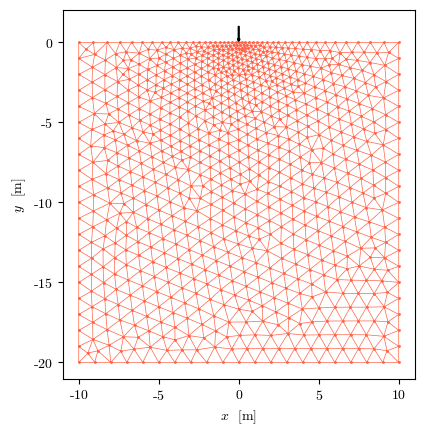

In [10]:
plot_mesh(nodes, elements, loads)

#### Displacements

/home/eamontoyaa/.pyenv/versions/3.9.13/envs/solidspy-env/lib/python3.9/site-packages/solidspy/postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


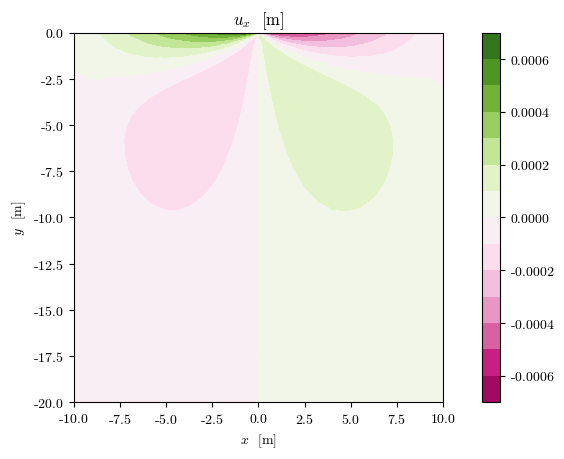

In [11]:
pos.plot_node_field(disp[:, 0], nodes, elements, title=["$u_x$  [m]"]);
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

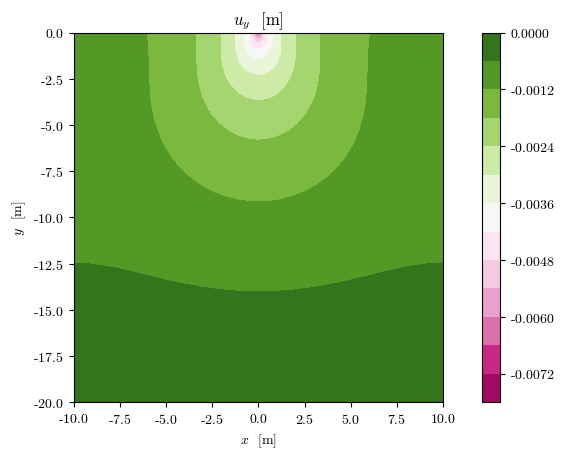

In [12]:
pos.plot_node_field(disp[:, 1], nodes, elements, title=["$u_y$  [m]"]);
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

#### Strain

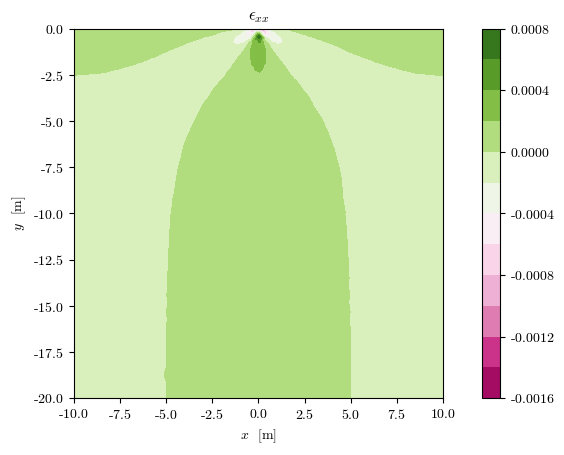

In [13]:
pos.plot_node_field(strain[:, 0], nodes, elements, title=["$\epsilon_{xx}$"])
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

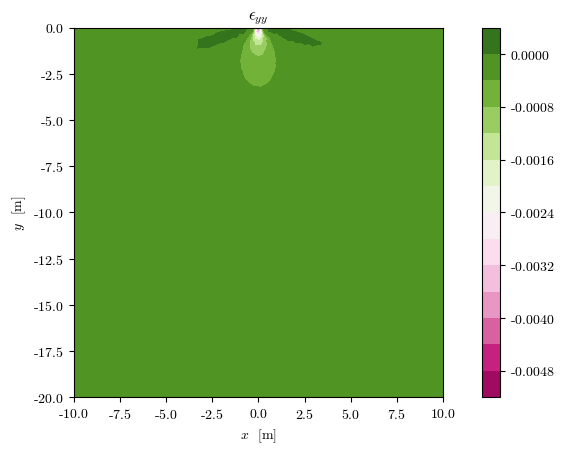

In [14]:
pos.plot_node_field(strain[:, 1], nodes, elements, title=["$\epsilon_{yy}$"])
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

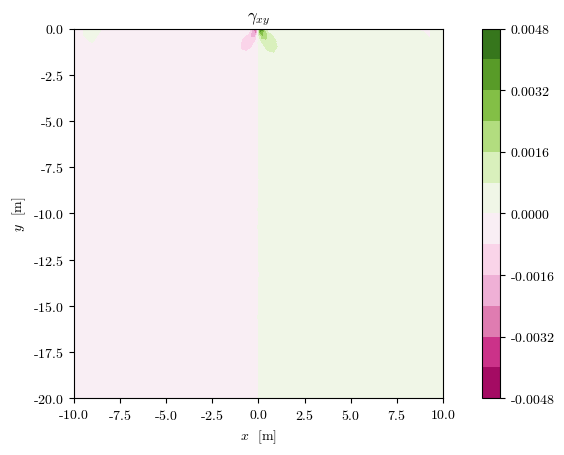

In [15]:
pos.plot_node_field(strain[:, 2], nodes, elements, title=["$\gamma_{xy}$"])
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

#### Cartesian stress

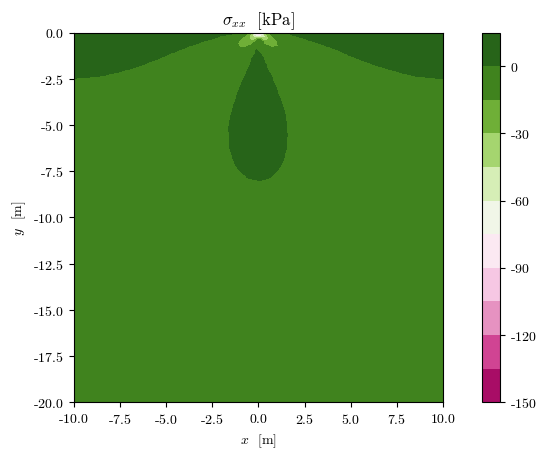

In [16]:
pos.plot_node_field(sigma_xx, nodes, elements, title=["$\sigma_{xx}$  [kPa]"])
plt.clim(min(sigma_xx.min(), sigma_xx_a.min()), max(sigma_xx.max(), sigma_xx_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

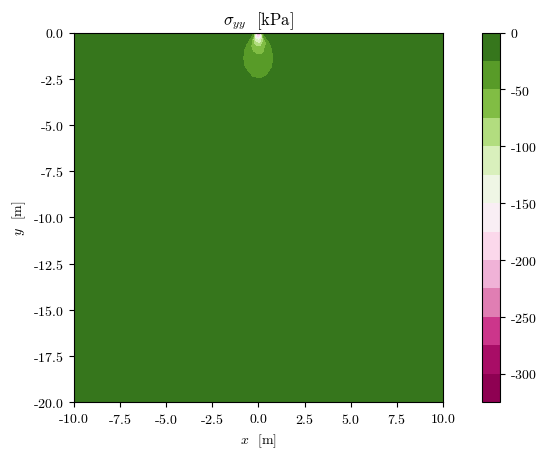

In [17]:
pos.plot_node_field(sigma_yy, nodes, elements, title=["$\sigma_{yy}$  [kPa]"])
plt.clim(min(sigma_yy.min(), sigma_yy_a.min()), max(sigma_yy.max(), sigma_yy_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

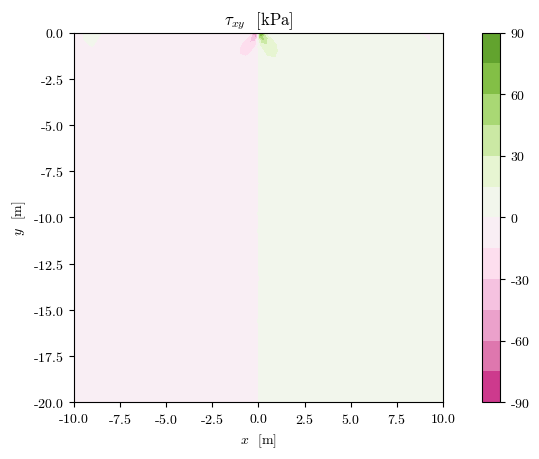

In [18]:
pos.plot_node_field(tau_xy, nodes, elements, title=["$\\tau_{xy}$  [kPa]"])
plt.clim(min(tau_xy.min(), tau_xy_a.min()), max(tau_xy.max(), tau_xy_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

#### Principal stress and directions

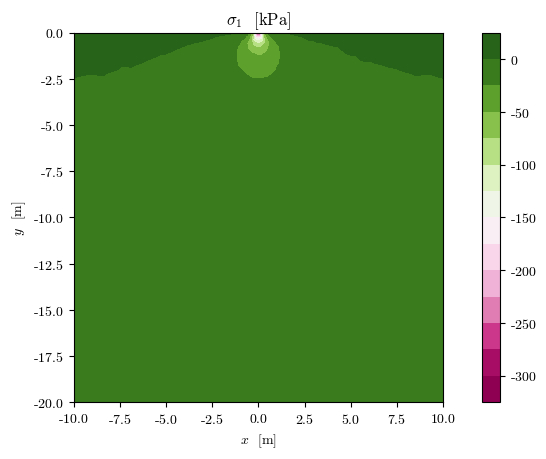

In [19]:
plot_principal_directions = False
pos.plot_node_field(sigma_1, nodes, elements, title=['$\sigma_1$  [kPa]']);
if plot_principal_directions:
    plt.quiver(x, y, *sigma_1*vecs1.T, headwidth=0);
    plt.quiver(x, y, *-sigma_1*vecs1.T, color='k', headwidth=0);
plt.clim(min(sigma_1.min(), sigma_1_a.min()), max(sigma_1.max(), sigma_1_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

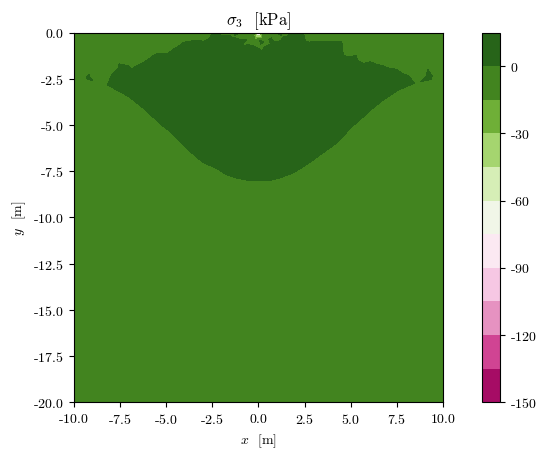

In [20]:
plot_principal_directions = False
pos.plot_node_field(sigma_3, nodes, elements, title=['$\sigma_3$  [kPa]']);
if plot_principal_directions:
    plt.quiver(x, y, *sigma_3*vecs3.T, units='width', headwidth=0);
    plt.quiver(x, y, *-sigma_3*vecs3.T, color='k', units='width', headwidth=0);
plt.clim(min(sigma_3.min(), sigma_3_a.min()), max(sigma_3.max(), sigma_3_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

### Analytical solution

#### Cartesian stress

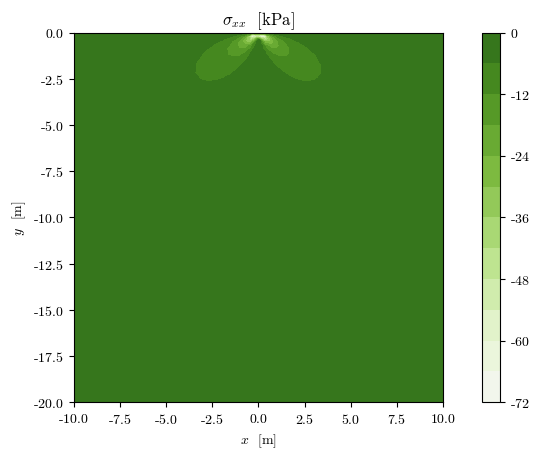

In [21]:
pos.plot_node_field(sigma_xx_a, nodes, elements, title=['$\sigma_{xx}$  [kPa]']);
plt.clim(min(stress[:, 0].min(), sigma_xx_a.min()), max(stress[:, 0].max(), sigma_xx_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

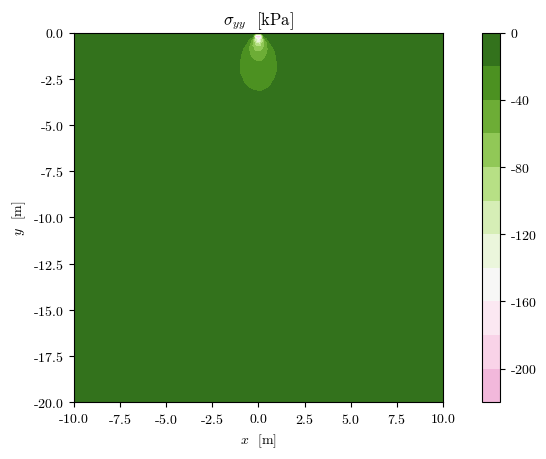

In [22]:
pos.plot_node_field(sigma_yy_a, nodes, elements, title=['$\sigma_{yy}$  [kPa]']);
plt.clim(min(stress[:, 1].min(), sigma_yy_a.min()), max(stress[:, 1].max(), sigma_yy_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

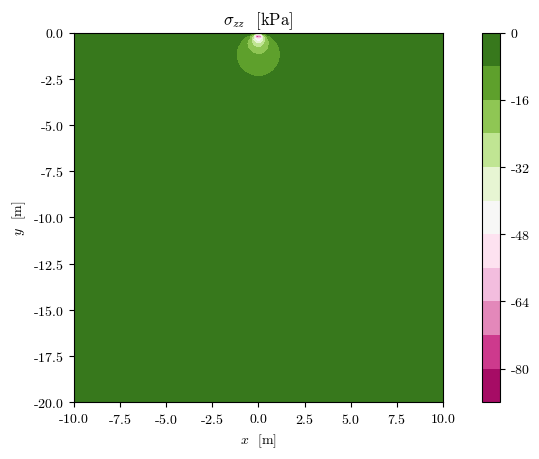

In [23]:
pos.plot_node_field(sigma_zz_a, nodes, elements, title=['$\sigma_{zz}$  [kPa]']);
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

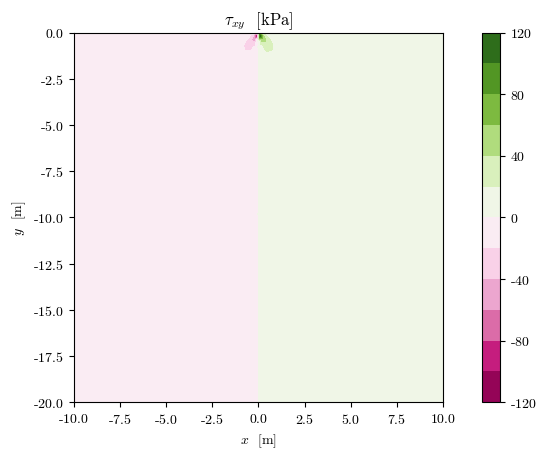

In [24]:
pos.plot_node_field(tau_xy_a, nodes, elements, title=['$\\tau_{xy}$  [kPa]']);
plt.clim(min(stress[:, 2].min(), tau_xy_a.min()), max(stress[:, 2].max(), tau_xy_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

#### Principal stress and directions

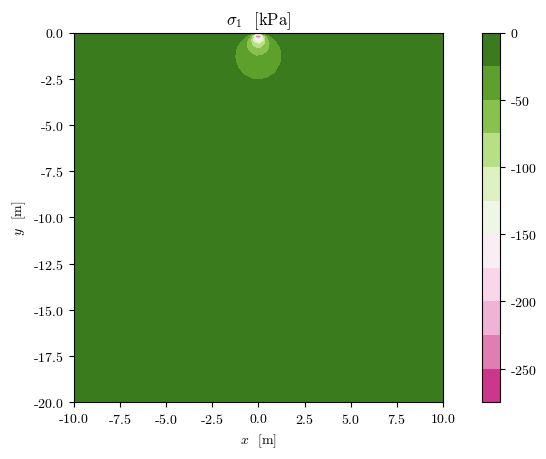

In [25]:
pos.plot_node_field(sigma_1_a, nodes, elements, title=['$\sigma_1$  [kPa]']);
plt.clim(min(sigma_1.min(), sigma_1_a.min()), max(sigma_1.max(), sigma_1_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

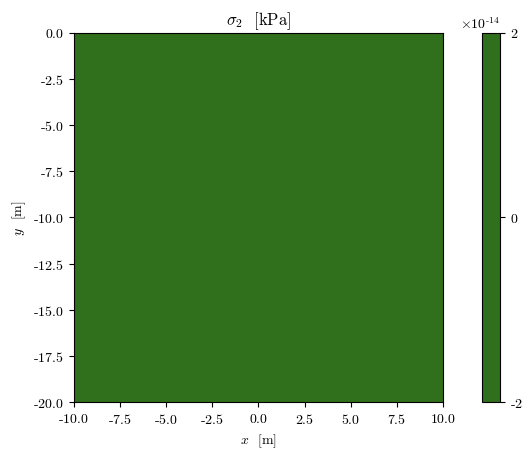

In [26]:
pos.plot_node_field(sigma_2_a, nodes, elements, title=['$\sigma_2$  [kPa]']);
plt.clim(min(sigma_3.min(), sigma_3_a.min()), max(sigma_3.max(), sigma_3_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

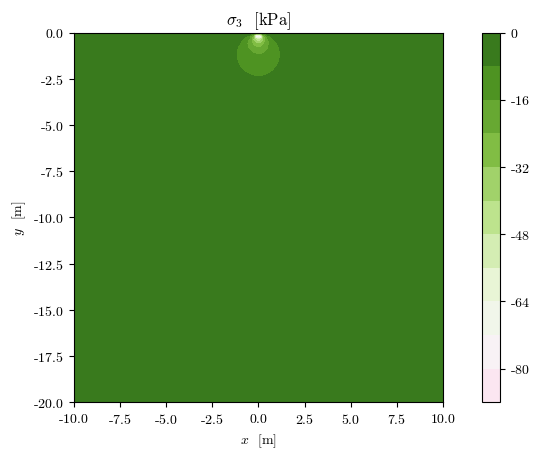

In [27]:
pos.plot_node_field(sigma_3_a, nodes, elements, title=['$\sigma_3$  [kPa]']);
plt.clim(min(sigma_3.min(), sigma_3_a.min()), max(sigma_3.max(), sigma_3_a.max()))
plt.xlabel('$x$  [m]');
plt.ylabel('$y$  [m]');

## FEM vs Analytical solutions

In [29]:
x = 1  # x-coordinate [m]
y = -2  # y-coordinate [m]
field = 'yy'  # You can choose among 'xx', 'yy', 'xy', '1' or '3'
compare_solutions(x, y, field)

𝜎_yy at (1, -2) by FEM is -20.36 kPa
𝜎_yy at (1, -2) by analytical solution is -20.37 kPa
